In [1]:
import gc
import pandas as pd 
import numpy as np
from sklearn import preprocessing
import matplotlib.pyplot as plt
from fancyimpute import KNN, NuclearNormMinimization, SoftImpute, BiScaler #We use the train dataframe from Titanic dataset#fancy impute removes column names.
from sklearn.linear_model import LogisticRegression
import statistics
from sklearn import preprocessing
from numpy import loadtxt
from xgboost import plot_importance
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score

Using TensorFlow backend.


Execute only one of the following 3 cells to load the desired dateset.
Each of the cells sets up the target and column to study for imputation.

In [ ]:
data = pd.read_csv("diabetes.csv",sep=',') 
data = pd.DataFrame(data) 

smallColumns = ['Pregnancies','BloodPressure','SkinThickness','Glucose','BMI','DiabetesPedigreeFunction','Age']
imputeCol=['Insulin']
targetCol=['Outcome']

In [ ]:
data = pd.read_csv("creditcard.csv",sep=',') 
data = pd.DataFrame(data) 
data=data.drop('Time', axis=1)
smallColumns = ['V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11',
       'V12', 'V13', 'V14', 'V15', 'V16', 'V28', 'V18', 'V19', 'V20', 'V21',
       'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'Amount']
#smallColumns = ['V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11',
#       'V12', 'V13', 'V14', 'V15', 'V16', 'V17']
#smallColumns = ['V14','V4','V17','V10']

imputeCol=['V17']
targetCol=['Class']
data.columns

xClass=data[data.Class==0]

msk3 = np.random.rand(len(data[data.Class==0])) < .1
xData = xClass[msk3]
data=xData.append(pd.DataFrame(data = data[data.Class==1]), ignore_index=True)
#https://www.kaggle.com/mlg-ulb/creditcardfraud/downloads/creditcardfraud.zip/3

In [2]:
data = pd.read_csv("titanic.csv",sep='\t') 
data = pd.DataFrame(data) 




le = preprocessing.LabelEncoder()

le.fit(data['Sex'])
list(le.classes_)
data['Sex']=le.transform(data['Sex']) 


embarkedCols=pd.get_dummies(data['Embarked'],prefix='Embarked', drop_first=True)
data = pd.concat([data[['Pclass','Age','SibSp','Parch','Fare','Sex','Survived']],embarkedCols], axis=1)

data=data.astype({'Pclass': 'float64','SibSp': 'float64','Parch': 'float64','Sex': 'float64','Embarked_Q': 'float64','Embarked_S': 'float64'})

smallColumns = ['Sex','SibSp','Parch','Fare','Age','Embarked_Q','Embarked_S']
imputeCol=['Pclass']
targetCol=['Survived']


In [3]:
#the following will set up the dataset to use after scaling
tempToScaleData = data[smallColumns+imputeCol]
scaler0 = preprocessing.StandardScaler().fit(tempToScaleData)
scaledData0 = scaler0.transform(tempToScaleData) 
scaledData0 = pd.DataFrame(scaledData0, index=tempToScaleData.index, columns=tempToScaleData.columns)
data=pd.concat([scaledData0, data[targetCol]], axis=1, sort=False)

The following is a function to set up imputation, set amount missing in training and set number of iterations to perform

In [4]:
def makeItSo(impute='median',missing=0.0,iters=50):

    scoreArr=[]
    #missing=0.0
    #impute='median'#'knn'
    #iters=50
    i=0
    while(i<iters):

        msk = np.random.rand(len(data)) < 0.8
        train = data[msk]
        test = data[~msk]





        msk2 = np.random.rand(len(train)) < missing
        t1 = train[msk2]
        t1[imputeCol]=np.nan
        t2 = train[~msk2]
        trainWNaNs = t1.append(pd.DataFrame(data = t2), ignore_index=True)


#Pregnancies 	Glucose 	BloodPressure 	SkinThickness 	Insulin 	BMI 	DiabetesPedigreeFunction 	Age 	Outcome
        if(missing==1):
            trainWNaNs[imputeCol]=0
        if(impute=='median'): 
            train0=trainWNaNs[smallColumns+imputeCol]
            train0[imputeCol]=train0[imputeCol].fillna(trainWNaNs[imputeCol].median(), inplace=False)
        elif(impute=='0'): #will impute a constant of -999
            train0=trainWNaNs[smallColumns+imputeCol]
            train0[imputeCol]=train0[imputeCol].fillna(-999, inplace=False)
        elif(impute=='KNN'):
            print('knn')
            train0=trainWNaNs[smallColumns+imputeCol]
            train_cols = list(train0)
            train0 = pd.DataFrame(KNN(k=3).fit_transform(train0))
            train0.columns = train_cols


        trainImputed = pd.concat([trainWNaNs[targetCol], train0], axis=1)

        trainImputed=trainImputed[smallColumns+imputeCol+targetCol]
        test=test[smallColumns+imputeCol+targetCol]

        trainImputed=trainImputed.dropna()
        test=test.dropna()
        train_X=trainImputed.drop([targetCol[0]], axis=1)
        train_Y=trainImputed[targetCol[0]]
        test_X=test.drop([targetCol[0]], axis=1)
        test_Y=test[targetCol[0]]

        if(missing==1 and True==False):
            train_X=train_X.drop([imputeCol[0]], axis=1)
            test_X=test_X.drop([imputeCol[0]], axis=1)

        # all parameters not specified are set to their defaults
        #logisticRegr = LogisticRegression()
        #logisticRegr.fit(train_X, train_Y)
        
        scaler = preprocessing.StandardScaler().fit(train_X)
        scaledXtrain = scaler.transform(train_X)   
        
        
        model = XGBClassifier()
        #silent=True,scale_pos_weight=1,learning_rate=0.01,colsample_bytree = 0.4,subsample = 0.8,objective='binary:logistic',n_estimators=500,reg_alpha = 0.3,max_depth=3,gamma=1
        
                    
        model.fit(scaledXtrain, train_Y)

        scaledXtest = scaler.transform(test_X) 

        # Use score method to get accuracy of model
        #score = logisticRegr.score(test_X, test_Y)
        
        y_pred = model.predict(scaledXtest)
        if(min(test_Y)!=max(test_Y)):
            auc=roc_auc_score(test_Y, y_pred)
            scoreArr.append(auc)
        #print('score: '+str(score))
        #print('AUC: '+str(auc))



        i=i+1
        print('missing:'+str(missing)+' / '+str(i)+'/'+str(iters)+' : '+str(impute))
    return scoreArr


In [9]:
#set up missingness list to test and number of iterations to perform for each imputation type
toPlot = pd.DataFrame(columns=['missingRate', 'AUC','imputationType'])
iters=10
#goThrough=[0.0,.1,.2,.3,.4,.5,.6,.7,.8,.9,1,0.05,.15,.25,.35,.45,.55,.65,.75,.85,.95]
goThrough=[0.0,.1,.2,.3,.4,.5,.6,.7,.8,.9,1]
#goThrough=[0.0,.2,.4,.6,.8,1]
#goThrough=[0.0,.5,1]
#goThrough=[1]
top=[]

In [10]:
#run through median impute method


impute='median'
for i in goThrough: 
    imis = makeItSo(impute=impute,missing=i,iters=iters)
    toPlotSub = pd.DataFrame(columns=['missingRate', 'AUC','imputationType'])
    toPlotSub['AUC']=imis
    toPlotSub['missingRate']=i
    toPlotSub['imputationType']=impute
    toPlot=toPlot.append(toPlotSub, ignore_index=True)


C:\Users\family\Anaconda3\envs\retroImpute\lib\site-packages\ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


missing:0.0 / 1/10 : median


C:\Users\family\Anaconda3\envs\retroImpute\lib\site-packages\ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\family\Anaconda3\envs\retroImpute\lib\site-packages\pandas\core\frame.py:3391: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[k1] = value[k2]


missing:0.0 / 2/10 : median


C:\Users\family\Anaconda3\envs\retroImpute\lib\site-packages\ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\family\Anaconda3\envs\retroImpute\lib\site-packages\pandas\core\frame.py:3391: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[k1] = value[k2]
C:\Users\family\Anaconda3\envs\retroImpute\lib\site-packages\ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the d

missing:0.0 / 3/10 : median
missing:0.0 / 4/10 : median


C:\Users\family\Anaconda3\envs\retroImpute\lib\site-packages\pandas\core\frame.py:3391: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[k1] = value[k2]
C:\Users\family\Anaconda3\envs\retroImpute\lib\site-packages\ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\family\Anaconda3\envs\retroImpute\lib\site-packages\pandas\core\frame.py:3391: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the 

missing:0.0 / 5/10 : median


C:\Users\family\Anaconda3\envs\retroImpute\lib\site-packages\ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\family\Anaconda3\envs\retroImpute\lib\site-packages\pandas\core\frame.py:3391: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[k1] = value[k2]


missing:0.0 / 6/10 : median


C:\Users\family\Anaconda3\envs\retroImpute\lib\site-packages\ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\family\Anaconda3\envs\retroImpute\lib\site-packages\pandas\core\frame.py:3391: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[k1] = value[k2]


missing:0.0 / 7/10 : median
missing:0.0 / 8/10 : median


C:\Users\family\Anaconda3\envs\retroImpute\lib\site-packages\ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\family\Anaconda3\envs\retroImpute\lib\site-packages\pandas\core\frame.py:3391: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[k1] = value[k2]
C:\Users\family\Anaconda3\envs\retroImpute\lib\site-packages\ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the d

missing:0.0 / 9/10 : median
missing:0.0 / 10/10 : median


C:\Users\family\Anaconda3\envs\retroImpute\lib\site-packages\ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\family\Anaconda3\envs\retroImpute\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
C:\Users\family\Anaconda3\envs\retroImpute\lib\site-packages\pandas\core\frame.py:3391: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the 

missing:0.5 / 1/10 : median


C:\Users\family\Anaconda3\envs\retroImpute\lib\site-packages\ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\family\Anaconda3\envs\retroImpute\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
C:\Users\family\Anaconda3\envs\retroImpute\lib\site-packages\pandas\core\frame.py:3391: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the 

missing:0.5 / 2/10 : median


C:\Users\family\Anaconda3\envs\retroImpute\lib\site-packages\ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\family\Anaconda3\envs\retroImpute\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
C:\Users\family\Anaconda3\envs\retroImpute\lib\site-packages\pandas\core\frame.py:3391: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the 

missing:0.5 / 3/10 : median


C:\Users\family\Anaconda3\envs\retroImpute\lib\site-packages\ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\family\Anaconda3\envs\retroImpute\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
C:\Users\family\Anaconda3\envs\retroImpute\lib\site-packages\pandas\core\frame.py:3391: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the 

missing:0.5 / 4/10 : median


C:\Users\family\Anaconda3\envs\retroImpute\lib\site-packages\ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\family\Anaconda3\envs\retroImpute\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
C:\Users\family\Anaconda3\envs\retroImpute\lib\site-packages\pandas\core\frame.py:3391: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the 

missing:0.5 / 5/10 : median


C:\Users\family\Anaconda3\envs\retroImpute\lib\site-packages\ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\family\Anaconda3\envs\retroImpute\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
C:\Users\family\Anaconda3\envs\retroImpute\lib\site-packages\pandas\core\frame.py:3391: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the 

missing:0.5 / 6/10 : median


C:\Users\family\Anaconda3\envs\retroImpute\lib\site-packages\ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\family\Anaconda3\envs\retroImpute\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
C:\Users\family\Anaconda3\envs\retroImpute\lib\site-packages\pandas\core\frame.py:3391: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the 

missing:0.5 / 7/10 : median


C:\Users\family\Anaconda3\envs\retroImpute\lib\site-packages\ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\family\Anaconda3\envs\retroImpute\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
C:\Users\family\Anaconda3\envs\retroImpute\lib\site-packages\pandas\core\frame.py:3391: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the 

missing:0.5 / 8/10 : median


C:\Users\family\Anaconda3\envs\retroImpute\lib\site-packages\ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\family\Anaconda3\envs\retroImpute\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
C:\Users\family\Anaconda3\envs\retroImpute\lib\site-packages\pandas\core\frame.py:3391: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the 

missing:0.5 / 9/10 : median


C:\Users\family\Anaconda3\envs\retroImpute\lib\site-packages\ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\family\Anaconda3\envs\retroImpute\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
C:\Users\family\Anaconda3\envs\retroImpute\lib\site-packages\pandas\core\frame.py:3391: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the 

missing:0.5 / 10/10 : median
missing:1 / 1/10 : median


C:\Users\family\Anaconda3\envs\retroImpute\lib\site-packages\pandas\core\frame.py:3391: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[k1] = value[k2]
C:\Users\family\Anaconda3\envs\retroImpute\lib\site-packages\pandas\core\frame.py:3391: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[k1] = value[k2]


missing:1 / 2/10 : median
missing:1 / 3/10 : median


C:\Users\family\Anaconda3\envs\retroImpute\lib\site-packages\pandas\core\frame.py:3391: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[k1] = value[k2]
C:\Users\family\Anaconda3\envs\retroImpute\lib\site-packages\pandas\core\frame.py:3391: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[k1] = value[k2]


missing:1 / 4/10 : median
missing:1 / 5/10 : median


C:\Users\family\Anaconda3\envs\retroImpute\lib\site-packages\pandas\core\frame.py:3391: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[k1] = value[k2]
C:\Users\family\Anaconda3\envs\retroImpute\lib\site-packages\pandas\core\frame.py:3391: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[k1] = value[k2]


missing:1 / 6/10 : median
missing:1 / 7/10 : median


C:\Users\family\Anaconda3\envs\retroImpute\lib\site-packages\pandas\core\frame.py:3391: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[k1] = value[k2]
C:\Users\family\Anaconda3\envs\retroImpute\lib\site-packages\pandas\core\frame.py:3391: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[k1] = value[k2]


missing:1 / 8/10 : median
missing:1 / 9/10 : median


C:\Users\family\Anaconda3\envs\retroImpute\lib\site-packages\pandas\core\frame.py:3391: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[k1] = value[k2]
C:\Users\family\Anaconda3\envs\retroImpute\lib\site-packages\pandas\core\frame.py:3391: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[k1] = value[k2]


missing:1 / 10/10 : median


In [ ]:
#run through KNN impute method


impute='KNN'
for i in goThrough: 
    imis = makeItSo(impute=impute,missing=i,iters=iters)
    toPlotSub = pd.DataFrame(columns=['missingRate', 'AUC','imputationType'])
    toPlotSub['AUC']=imis
    toPlotSub['missingRate']=i
    toPlotSub['imputationType']=impute
    toPlot=toPlot.append(toPlotSub, ignore_index=True)


In [11]:
#run through extreme constant impute method
#will impute a constant of -999

impute='0'
for i in goThrough: 
    imis = makeItSo(impute=impute,missing=i,iters=iters)
    toPlotSub = pd.DataFrame(columns=['missingRate', 'AUC','imputationType'])
    toPlotSub['AUC']=imis
    toPlotSub['missingRate']=i
    toPlotSub['imputationType']=impute
    toPlot=toPlot.append(toPlotSub, ignore_index=True)


C:\Users\family\Anaconda3\envs\retroImpute\lib\site-packages\ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\family\Anaconda3\envs\retroImpute\lib\site-packages\pandas\core\frame.py:3391: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[k1] = value[k2]
C:\Users\family\Anaconda3\envs\retroImpute\lib\site-packages\ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the d

missing:0.0 / 1/10 : 0
missing:0.0 / 2/10 : 0
missing:0.0 / 3/10 : 0


C:\Users\family\Anaconda3\envs\retroImpute\lib\site-packages\ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\family\Anaconda3\envs\retroImpute\lib\site-packages\pandas\core\frame.py:3391: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[k1] = value[k2]
C:\Users\family\Anaconda3\envs\retroImpute\lib\site-packages\ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the d

missing:0.0 / 4/10 : 0
missing:0.0 / 5/10 : 0


C:\Users\family\Anaconda3\envs\retroImpute\lib\site-packages\ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\family\Anaconda3\envs\retroImpute\lib\site-packages\pandas\core\frame.py:3391: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[k1] = value[k2]
C:\Users\family\Anaconda3\envs\retroImpute\lib\site-packages\ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the d

missing:0.0 / 6/10 : 0


C:\Users\family\Anaconda3\envs\retroImpute\lib\site-packages\pandas\core\frame.py:3391: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[k1] = value[k2]
C:\Users\family\Anaconda3\envs\retroImpute\lib\site-packages\ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\family\Anaconda3\envs\retroImpute\lib\site-packages\pandas\core\frame.py:3391: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the 

missing:0.0 / 7/10 : 0
missing:0.0 / 8/10 : 0


C:\Users\family\Anaconda3\envs\retroImpute\lib\site-packages\ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\family\Anaconda3\envs\retroImpute\lib\site-packages\pandas\core\frame.py:3391: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[k1] = value[k2]


missing:0.0 / 9/10 : 0
missing:0.0 / 10/10 : 0


C:\Users\family\Anaconda3\envs\retroImpute\lib\site-packages\ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\family\Anaconda3\envs\retroImpute\lib\site-packages\pandas\core\frame.py:3391: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[k1] = value[k2]
C:\Users\family\Anaconda3\envs\retroImpute\lib\site-packages\ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the d

missing:0.5 / 1/10 : 0


C:\Users\family\Anaconda3\envs\retroImpute\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
C:\Users\family\Anaconda3\envs\retroImpute\lib\site-packages\pandas\core\frame.py:3391: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[k1] = value[k2]


missing:0.5 / 2/10 : 0


C:\Users\family\Anaconda3\envs\retroImpute\lib\site-packages\ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\family\Anaconda3\envs\retroImpute\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
C:\Users\family\Anaconda3\envs\retroImpute\lib\site-packages\pandas\core\frame.py:3391: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the 

missing:0.5 / 3/10 : 0


C:\Users\family\Anaconda3\envs\retroImpute\lib\site-packages\ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\family\Anaconda3\envs\retroImpute\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
C:\Users\family\Anaconda3\envs\retroImpute\lib\site-packages\pandas\core\frame.py:3391: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the 

missing:0.5 / 4/10 : 0


C:\Users\family\Anaconda3\envs\retroImpute\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
C:\Users\family\Anaconda3\envs\retroImpute\lib\site-packages\pandas\core\frame.py:3391: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[k1] = value[k2]
C:\Users\family\Anaconda3\envs\retroImpute\lib\site-packages\ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead



missing:0.5 / 5/10 : 0


C:\Users\family\Anaconda3\envs\retroImpute\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
C:\Users\family\Anaconda3\envs\retroImpute\lib\site-packages\pandas\core\frame.py:3391: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[k1] = value[k2]


missing:0.5 / 6/10 : 0


C:\Users\family\Anaconda3\envs\retroImpute\lib\site-packages\ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\family\Anaconda3\envs\retroImpute\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
C:\Users\family\Anaconda3\envs\retroImpute\lib\site-packages\pandas\core\frame.py:3391: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the 

missing:0.5 / 7/10 : 0


C:\Users\family\Anaconda3\envs\retroImpute\lib\site-packages\pandas\core\frame.py:3391: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[k1] = value[k2]
C:\Users\family\Anaconda3\envs\retroImpute\lib\site-packages\ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\family\Anaconda3\envs\retroImpute\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in th

missing:0.5 / 8/10 : 0


C:\Users\family\Anaconda3\envs\retroImpute\lib\site-packages\pandas\core\frame.py:3391: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[k1] = value[k2]
C:\Users\family\Anaconda3\envs\retroImpute\lib\site-packages\ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\family\Anaconda3\envs\retroImpute\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in th

missing:0.5 / 9/10 : 0


C:\Users\family\Anaconda3\envs\retroImpute\lib\site-packages\pandas\core\frame.py:3391: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[k1] = value[k2]
C:\Users\family\Anaconda3\envs\retroImpute\lib\site-packages\pandas\core\frame.py:3391: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[k1] = value[k2]


missing:0.5 / 10/10 : 0
missing:1 / 1/10 : 0


C:\Users\family\Anaconda3\envs\retroImpute\lib\site-packages\pandas\core\frame.py:3391: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[k1] = value[k2]
C:\Users\family\Anaconda3\envs\retroImpute\lib\site-packages\pandas\core\frame.py:3391: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[k1] = value[k2]


missing:1 / 2/10 : 0
missing:1 / 3/10 : 0


C:\Users\family\Anaconda3\envs\retroImpute\lib\site-packages\pandas\core\frame.py:3391: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[k1] = value[k2]
C:\Users\family\Anaconda3\envs\retroImpute\lib\site-packages\pandas\core\frame.py:3391: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[k1] = value[k2]


missing:1 / 4/10 : 0
missing:1 / 5/10 : 0


C:\Users\family\Anaconda3\envs\retroImpute\lib\site-packages\pandas\core\frame.py:3391: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[k1] = value[k2]
C:\Users\family\Anaconda3\envs\retroImpute\lib\site-packages\pandas\core\frame.py:3391: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[k1] = value[k2]


missing:1 / 6/10 : 0
missing:1 / 7/10 : 0


C:\Users\family\Anaconda3\envs\retroImpute\lib\site-packages\pandas\core\frame.py:3391: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[k1] = value[k2]
C:\Users\family\Anaconda3\envs\retroImpute\lib\site-packages\pandas\core\frame.py:3391: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[k1] = value[k2]


missing:1 / 8/10 : 0
missing:1 / 9/10 : 0
missing:1 / 10/10 : 0


C:\Users\family\Anaconda3\envs\retroImpute\lib\site-packages\pandas\core\frame.py:3391: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[k1] = value[k2]


In [1]:
#plot average performances

aggPlot = toPlot.groupby(['imputationType','missingRate']).mean()
p1 = toPlot.loc[toPlot['imputationType']=='KNN'].groupby(['missingRate']).mean()
p2 = toPlot.loc[toPlot['imputationType']=='median'].groupby(['missingRate']).mean()
p3 = toPlot.loc[toPlot['imputationType']=='0'].groupby(['missingRate']).mean()


plt.plot(p1)
plt.plot(p2)
plt.plot(p3)
plt.legend(['KNN', 'median', '-999'], loc='lower left')
plt.show()

NameError: name 'toPlot' is not defined

In [ ]:
print(toPlot.loc[toPlot['imputationType']=='KNN'][['AUC']].mean())
print(toPlot.loc[toPlot['imputationType']=='median'][['AUC']].mean())
#print(toPlot.loc[toPlot['imputationType']=='0'][['AUC']].mean())

In [ ]:
import seaborn as sns; 
sns.set(color_codes=True)

tips = toPlot.loc[toPlot['imputationType']=='KNN'][['missingRate','AUC']]
ax = sns.regplot(x="missingRate", y="AUC", data=tips,lowess=True)



In [ ]:
tips = toPlot.loc[toPlot['imputationType']=='median'][['missingRate','AUC']]
ax2 = sns.regplot(x="missingRate", y="AUC", data=tips,lowess=True)

In [ ]:
tips = toPlot.loc[toPlot['imputationType']=='0'][['missingRate','AUC']]
ax3 = sns.regplot(x="missingRate", y="AUC", data=tips,lowess=True)

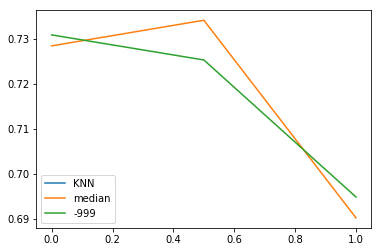

In [ ]:


plt.plot(t, t, 'r--', t, t**2, 'bs', t, t**3, 'g^')
plt.show()

In [ ]:
g = sns.FacetGrid(toPlot,col="imputationType")
g.map(plt.scatter, "missingRate", "AUC", alpha=.5)
g.add_legend();

In [ ]:
toPlot

In [ ]:
#STOPED HERE 9/8/2019

In [ ]:
toPlot=toPlot.append(toPlotSub)
toPlot

In [ ]:
scoreArr

In [ ]:
print('sd'+statistics.stdev(scoreArr))
print(statistics.mean(scoreArr))
print(statistics.median(scoreArr))

In [ ]:
    feature_importance = abs(logisticRegr.coef_[0])
    feature_importance = 100.0 * (feature_importance / feature_importance.max())
    sorted_idx = np.argsort(feature_importance)
    pos = np.arange(sorted_idx.shape[0]) + .5

    featfig = plt.figure()
    featax = featfig.add_subplot(1, 1, 1)
    featax.barh(pos, feature_importance[sorted_idx], align='center')
    featax.set_yticks(pos)
    featax.set_yticklabels(np.array(test.dropna().drop(['Survived'], axis=1).columns)[sorted_idx], fontsize=8)
    featax.set_xlabel('Relative Feature Importance')